In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
import pandas as pd
import glob, os
import numpy as np
import seaborn as sns
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

tslearn 미설치시 : pip install tslearn

## KMeans 알고리즘 군집화
- 데이터 간의 거리를 계산해서 군집화 하는 방식
- 기상데이터로 KMeans 군집화 진행

#### 최적의 군집 개수를 설정하기 위한 방법
- 엘보우 기법 : 군집 개수에 따른 SSE 값 측정
- 실루엣 계수

월별로 날씨 평균을 낸 뒤에 군집화를 진행 -> 어떤 월들끼리 날씨가 유사한지

In [19]:
기상데이터 = pd.read_csv("기상데이터.csv",encoding="utf-8-sig").dropna(axis=0,how="any")

In [20]:
from datetime import datetime
# datetime 객체로 변환하기
기상데이터["일시"] = 기상데이터["일시"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))

# 월 추출하기
기상데이터["월"] = 기상데이터["일시"].apply(lambda x : x.month)

In [21]:
기상데이터.head(2)

,일시,평균기온,최저기온,최고기온,일강수량,최대풍속,평균풍속,평균상대습도,평균이슬점온도,평균현지기압,평균증기압,합계일조시간,평균지면온도,체감온도,열지수,불쾌지수,월
0,2018-01-01,-0.218947,-4.775789,5.246316,0.0,5.072632,1.965263,51.204211,-10.228421,1013.687368,2.987368,8.222105,-0.008421,0.636883,24.316910,38.613327,1
1,2018-01-02,0.332979,-5.213830,6.002128,0.0,4.976596,1.882979,57.358511,-8.069149,1014.413830,3.586170,6.163158,-0.249474,1.225645,24.472175,38.525522,1


월별 평균 만들기

In [22]:
기상데이터_월 = 기상데이터.set_index("일시").groupby("월").mean()
기상데이터_월

,평균기온,최저기온,최고기온,일강수량,최대풍속,평균풍속,평균상대습도,평균이슬점온도,평균현지기압,평균증기압,합계일조시간,평균지면온도,체감온도,열지수,불쾌지수
월,,,,,,,,,,,,,,,
1,0.446477,-3.942260,5.521465,2.138074,4.980602,2.135413,61.341855,-6.983109,1010.653664,4.122840,5.565026,0.913647,1.237338,25.544356,38.414574
2,1.924122,-3.072485,7.379670,2.128455,5.090087,2.182381,59.015760,-6.327817,1010.480499,4.416993,6.331882,2.812520,2.666270,26.889520,40.844545
3,7.512667,2.031124,13.322205,3.149015,5.640484,2.425831,63.748234,0.051162,1004.972481,6.649958,6.444936,8.752475,8.404715,31.732463,48.017255
4,11.820404,6.397327,17.608262,4.182278,5.526586,2.373825,63.680455,3.892261,1002.871358,8.792253,6.839003,14.320821,12.991852,34.550716,54.247110
5,17.817494,12.644287,23.513245,4.495110,4.911548,2.058103,70.512998,11.352568,998.976062,14.038196,6.862461,21.308716,19.502560,37.725248,62.988970
6,21.821681,17.583268,26.987591,7.357480,4.408536,1.789983,75.503393,16.659097,994.801548,19.322536,6.467640,26.388036,23.809784,39.776059,69.396824
7,24.344260,21.104074,28.490578,10.649444,4.177613,1.786777,82.159093,20.698168,995.281201,24.771131,5.039975,27.684053,26.481947,41.479067,73.934780
8,26.486497,23.011633,31.011754,11.864790,4.429954,1.845316,80.848185,22.512596,996.080476,27.553138,6.099576,29.902454,28.737046,43.048342,77.280480
9,20.948197,17.243183,25.562835,9.115473,4.413473,1.805399,80.050841,16.944196,1000.960705,19.828417,4.840967,23.112044,22.950686,39.130747,68.454601


SSE 값을 확인해서 최적의 군집개수 3개 정도로 판단

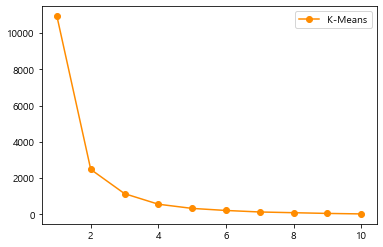

In [23]:
SSE = []
for i in range(1,11):
    kmeans = KMeans(max_iter=500,init="k-means++",n_clusters=i,random_state=0)
    kmeans.fit(기상데이터_월.values)
    SSE.append(np.round(kmeans.inertia_,3))

plt.plot(range(1,11),SSE,marker="o",label="K-Means",color="darkorange")
plt.legend(loc="upper right")
plt.show()

실루엣 계수 확인하기

In [24]:
for i in range(2,6):
    kmeans = KMeans(n_clusters=i,init="k-means++",max_iter=500,random_state=0)
    labels = kmeans.fit_predict(기상데이터_월.values)

    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(기상데이터_월.values,labels)
    print("군집의 개수가 {0}개 일 때, 실루엣 계수 : {1}".format(i,round(silhouette_avg,4)))

군집의 개수가 2개 일 때, 실루엣 계수 : 0.5857
군집의 개수가 3개 일 때, 실루엣 계수 : 0.5598
군집의 개수가 4개 일 때, 실루엣 계수 : 0.5239
군집의 개수가 5개 일 때, 실루엣 계수 : 0.5016


#### 군집 3개로 나눠보기

In [25]:
kmeans = KMeans(n_clusters=3,init="k-means++",max_iter=500,random_state=0)
labels = kmeans.fit_predict(기상데이터_월.values)

In [26]:
# 군집별로 column 중심점 파악
centers = kmeans.cluster_centers_
centers.shape

(3, 15)

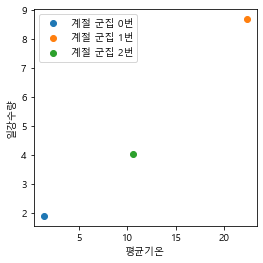

In [31]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(3):
    
    # 군집별로 다르게 매핑
    df = pd.DataFrame(data = centers[i].reshape(1,-1),columns = 기상데이터_월.columns)

    ax.scatter(x= df.loc[:,"평균기온"],y = df.loc[:,"일강수량"],label="계절 군집 " + str(i)+"번")
    ax.legend()
    ax.set_xlabel("평균기온")
    ax.set_ylabel("일강수량")

#### 군집 해석하기
- 군집 0번은 평균기온과 강수량이 적은 군집 -> 12,1,2월
- 군집 1번은 평균기온과 강수량이 높은 군집 -> 5,6,7,8,9월

In [39]:
군집정보 = pd.DataFrame(index=기상데이터_월.index,columns=["군집"])
군집정보["군집"] = labels

In [40]:
# 군집 0번만 출력
군집정보[군집정보["군집"] == 0]

,군집
월,
1,0
2,0
12,0


In [42]:
# 군집 2번만 출력
군집정보[군집정보["군집"] == 1]

,군집
월,
5,1
6,1
7,1
8,1
9,1
